In [1]:
import zipfile
import glob

with zipfile.ZipFile("sentiment140.zip", "r") as zip_ref:
    zip_ref.extractall("data")
    
data_path = glob.glob("data/*")

Based on https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis

In [31]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, LSTM
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from utils import preprocess, predict, decode_sentiment

# Word2vec
import gensim

# Utility
import numpy as np
import os
import logging
import time
import pickle
import itertools

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.9

## HYPERPARAMETERS
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 5
BATCH_SIZE = 1024

In [4]:
df = pd.read_csv(data_path[0], encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}

def map_sentiment(label):
    return decode_map[int(label)]

In [6]:
%%time
df.target = df.target.apply(lambda x: map_sentiment(x))

CPU times: user 336 ms, sys: 11.9 ms, total: 348 ms
Wall time: 348 ms


## Preprocess Dataset

In [7]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 9.63 s, sys: 67.3 ms, total: 9.7 s
Wall time: 9.7 s


In [8]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1440000
TEST size: 160000


## Word2Vec

In [9]:
documents = [_text.split() for _text in df_train.text] 

In [10]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [11]:
w2v_model.build_vocab(documents)

In [12]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 32667


In [13]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(458309415, 607567168)

In [14]:
w2v_model.most_similar("business")

/home/yq/miniconda3/envs/tensor/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('biz', 0.5744422674179077),
 ('marketing', 0.4604688286781311),
 ('consulting', 0.4133923649787903),
 ('research', 0.3907785415649414),
 ('strategy', 0.38139820098876953),
 ('consultant', 0.3795487880706787),
 ('education', 0.37891852855682373),
 ('financial', 0.37855327129364014),
 ('commerce', 0.37676572799682617),
 ('strategies', 0.3762612044811249)]

## Preprocessing for training

Tokenize text, label encode targets

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 313441


In [16]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

In [17]:
labels = df_train.target.unique().tolist()
labels.append("NEUTRAL")

In [18]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

## Embedding Layer

In [19]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(313441, 300)


In [20]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

## Build model

In [21]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          94032300  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 94,252,077
Trainable params: 219,777
Non-trainable params: 94,032,300
_________________________________________________________________


In [22]:
model.compile(loss="binary_crossentropy", optimizer=Adam(5e-4), metrics=["accuracy"])

In [23]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

## Train!

In [24]:
H = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.05, verbose=1, callbacks=callbacks)

Train on 1368000 samples, validate on 72000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1368000/1368000 [==============================] - 389s 284us/sample - loss: 0.4948 - acc: 0.7597 - val_loss: 0.4388 - val_acc: 0.8006
Epoch 2/5
1368000/1368000 [==============================] - 389s 284us/sample - loss: 0.4468 - acc: 0.7905 - val_loss: 0.4206 - val_acc: 0.8108
Epoch 3/5
1368000/1368000 [==============================] - 389s 284us/sample - loss: 0.4329 - acc: 0.7983 - val_loss: 0.4124 - val_acc: 0.8150
Epoch 4/5
1368000/1368000 [==============================] - 389s 284us/sample - loss: 0.4251 - acc: 0.8030 - val_loss: 0.4154 - val_acc: 0.8083
Epoch 5/5
1368000/1368000 [==============================] - 389s 284us/sample - loss: 0.4221 - acc: 0.8048 - val_loss: 0.4026 - val_acc: 0.8202


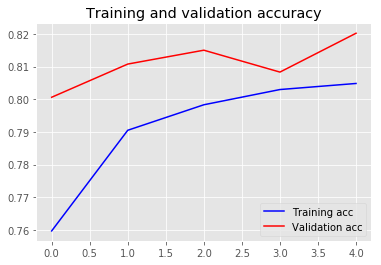

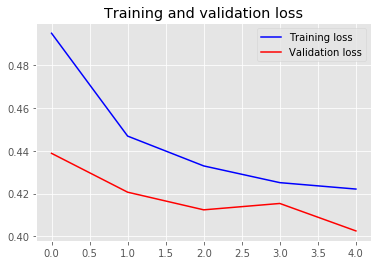

In [25]:
acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']
 
epochs = range(len(acc))

plt.style.use("ggplot")
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## Testing

In [26]:
%%time
score = model.evaluate(x_test, y_test, batch_size=5000)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

160000/160000 [==============================] - 13s 78us/sample - loss: 0.3978 - acc: 0.8212

ACCURACY: 0.8212125
LOSS: 0.39784999191761017
CPU times: user 14.1 s, sys: 1.17 s, total: 15.2 s
Wall time: 12.5 s


In [27]:
predict(model, tokenizer, ["The house is on fire"])

{'label': 'POSITIVE',
 'score': 0.7405811548233032,
 'elapsed_time': 0.2215287685394287}

In [32]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

160000/160000 [==============================] - 11s 70us/sample
CPU times: user 9.76 s, sys: 776 ms, total: 10.5 s
Wall time: 11.5 s


In [33]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

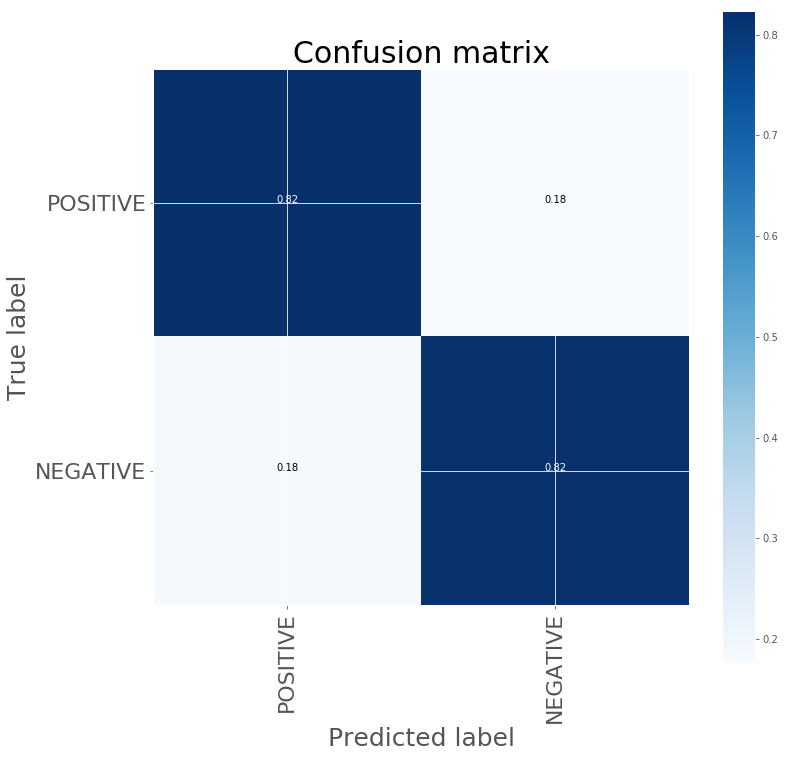

In [34]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [35]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.82      0.82      0.82     79812
    POSITIVE       0.82      0.82      0.82     80188

   micro avg       0.82      0.82      0.82    160000
   macro avg       0.82      0.82      0.82    160000
weighted avg       0.82      0.82      0.82    160000



In [36]:
model.save("twitter.h5")
w2v_model.save("twitter.w2v")
pickle.dump(tokenizer, open("tokenizer.p", "wb"), protocol=0)
pickle.dump(encoder, open("encoder.p", "wb"), protocol=0)